In [ ]:
import tensorflow as tf

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [ ]:
import numpy as np

In [ ]:
cd drive/MyDrive/

/content/drive/MyDrive


In [ ]:
imagen_original = "imagenesGAN/mardelplata2.png"
style = "imagenesGAN/vangoh.png"

nombre_img = imagen_original.split('/')[1]
nombre_img = nombre_img.split('.')[0]

Supongamos que queremos calcular el coste de estilo en una capa. Para ello, lo primero que debemos hacer es aplanar (flatten) nuestra capa. Esto es algo bueno, ya que el cálculo del Gram Matrix no cambiará en función del tamaño de la capa.

Así pues, supongamos que hacemos un flatten sobre una capa de 3 filtros. Pues bien, el Gram Matrix muestra la similitud entre los filtros y se obtiene calculando producto escalar entre los vectores:

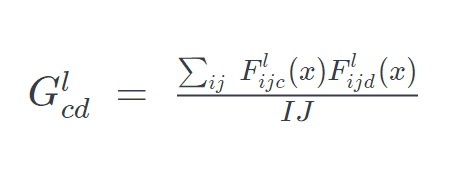

In [ ]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def coste_estilo(style, combination,size=255 * 255):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def coste_contenido(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

Para programar una Neural Style Transfer (en este caso en Python), al igual que en una GAN, partiremos de una imagen base. Como he comentado, esta imagen puede ser o bien ‘ruido’ o la propia imagen de base (generalmente se suele usar la imagen base ya que suele ser más rápido).

Esta imagen la pasaremos por una red neuronal convolucional de clasificación. Generalmente se suelen aprovechar redes neuronales ya creadas. En nuestro caso, usaremos la red VGG19 entrenada con el dataset ImageNet, la cual es una red neuronal que ofrece Keras.

In [ ]:
from tensorflow.keras.applications import vgg19
from keras.utils import plot_model

model = vgg19.VGG19(weights="imagenet", include_top=False)

model.summary()


80134624/80134624 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
from keras import Model

outputs_dict= dict([(layer.name, layer.output) for layer in model.layers])

feature_extractor = Model(inputs=model.inputs, outputs=outputs_dict)


In [ ]:
capas_estilo = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

capas_contenido = "block5_conv2"

content_weight = 2.5e-8 # default: 2.5e-8
style_weight = 1e-6 # default: 1e-6

def loss_function(combination_image, base_image, style_reference_image):

    # 1. Combinar todas las imágenes en un mismo tensor.
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )

    # 2. Obtener los valores en todas las capas para las tres imágenes
    features = feature_extractor(input_tensor)

    #3. Inicializar el coste
    loss = tf.zeros(shape=())

    # 4. Extraer las capas de contenido + coste de contenido
    layer_features = features[capas_contenido]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]

    loss = loss + content_weight * coste_contenido(
        base_image_features, combination_features
    )
    # 5. Extraer las capas de estilo + coste de estilo
    for layer_name in capas_estilo:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = coste_estilo(style_reference_features, combination_features)
        loss += (style_weight / len(capas_estilo)) * sl

    return loss


In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = loss_function(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads


In [ ]:
import keras
from tensorflow.keras.applications import vgg19
import numpy as np


def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

def deprocess_image(x):

    # Convertimos el tensor en Array
    x = x.reshape((img_nrows, img_ncols, 3))

    # Hacemos que no tengan promedio 0
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # Convertimos de BGR a RGB.
    x = x[:, :, ::-1]

    # Nos aseguramos que están entre 0 y 255
    x = np.clip(x, 0, 255).astype("uint8")

    return x


In [ ]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
# Create name
now = datetime.now()
now = now.strftime("%Y%m%d_%H%M%S")

checkpoint_filepath = 'instanciasGAN/model_checkpoint_' + str(now) + '.h5'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True
)

def result_saver(iteration):

  #model_name = str(i) + '_' + str(now)+"_model_" + '.h5'
  image_name = "ResultadosStyle/" + nombre_img + '_' + str(i) + '_' + str(now)+"_image" + '.png'

  # Save model and image
  img = deprocess_image(combination_image.numpy())
  keras.preprocessing.image.save_img(image_name, img)

  return image_name

Entrenamiento de la Neural Style Transfer

In [ ]:
from keras.optimizers import SGD

width, height = keras.preprocessing.image.load_img(imagen_original).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)


optimizer = SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(imagen_original)
style_reference_image = preprocess_image(style)
combination_image = tf.Variable(preprocess_image(imagen_original))

iterations = 4000
y_loss = []
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])

    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img_final = result_saver(i)
    y_loss.append(loss)

model.save(checkpoint_filepath)

Iteration 100: loss=1397.45
Iteration 200: loss=827.12
Iteration 300: loss=603.65
Iteration 400: loss=487.87
Iteration 500: loss=416.95
Iteration 600: loss=368.83
Iteration 700: loss=333.79
Iteration 800: loss=307.01
Iteration 900: loss=285.83
Iteration 1000: loss=268.64
Iteration 1100: loss=254.43
Iteration 1200: loss=242.44
Iteration 1300: loss=232.19
Iteration 1400: loss=223.34
Iteration 1500: loss=215.61
Iteration 1600: loss=208.80
Iteration 1700: loss=202.75
Iteration 1800: loss=197.36
Iteration 1900: loss=192.51
Iteration 2000: loss=188.14
Iteration 2100: loss=184.18
Iteration 2200: loss=180.57
Iteration 2300: loss=177.27
Iteration 2400: loss=174.25
Iteration 2500: loss=171.47
Iteration 2600: loss=168.92
Iteration 2700: loss=166.55
Iteration 2800: loss=164.36
Iteration 2900: loss=162.33
Iteration 3000: loss=160.44
Iteration 3100: loss=158.68
Iteration 3200: loss=157.04
Iteration 3300: loss=155.51
Iteration 3400: loss=154.07
Iteration 3500: loss=152.72
Iteration 3600: loss=151.46


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Iteration 4000: loss=147.11


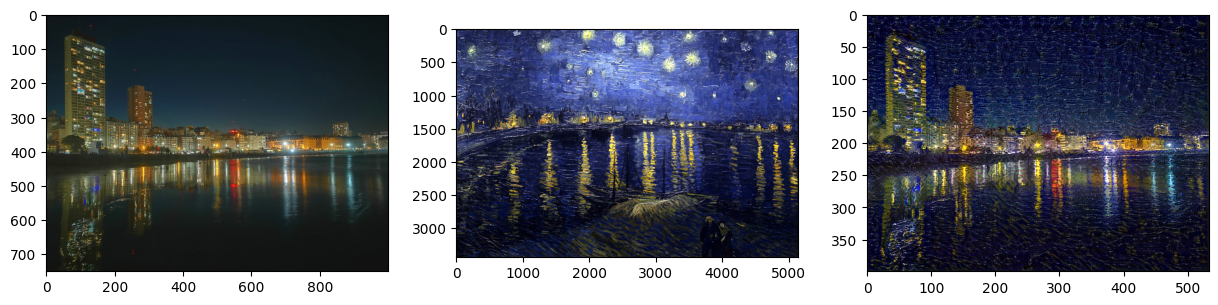

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# read the image file in a numpy array
a = plt.imread(imagen_original)
b = plt.imread(style)
c = plt.imread(img_final)
f, axarr = plt.subplots(1,3, figsize=(15,15))
axarr[0].imshow(a)
axarr[1].imshow(b)
axarr[2].imshow(c)
plt.show()

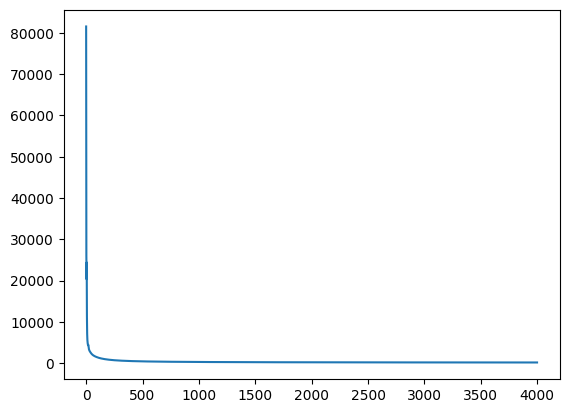

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(iterations),y_loss)


In [ ]:
ultima_ruta = "instanciasGAN/model_checkpoint_20231126_022607.h5"
model.load_weights(ultima_ruta)